# シンプルな予測ベースのトレードルール

input:現在の日付、所持金、取り扱いデータ（dataframe）<br>
output:更新された所持金<br>

In [229]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [230]:
#パラメータ
current_day = '2021-06-07'
posses = {'JPY':10000,'USD':0}
jpy_usd = pd.read_csv('../temp_data/jpy_usd.csv')

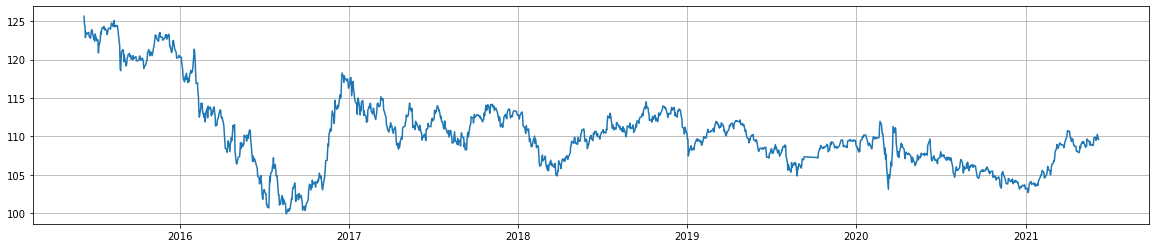

In [231]:
jpy_usd.index = pd.to_datetime(jpy_usd['Date'])
del jpy_usd['Date']
next_day = jpy_usd[current_day:].index[0]
jpy_usd = jpy_usd[:current_day]
plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Close'])
plt.grid()
plt.show()

In [232]:
#次の1日の分行を足しておく
jpy_usd.loc[next_day] = 0

In [233]:
def ema(s, term=5):
    '''指数平滑移動平均の計算'''
    sma = s.rolling(term).mean()[:term]
    return pd.concat([sma, s[term:]]).ewm(span=term, adjust=False).mean()

def calc_macd(s,short_term=12,long_term=26, signal_term=9):
    """
    s: pd.Series、為替データ
    return: macd,macd_signal
    """
    short_term_ema = ema(s,short_term)
    long_term_ema = ema(s,long_term)
    macd = short_term_ema - long_term_ema
    macd_signal = ema(macd,signal_term)
    return macd,macd_signal

def out_cross_flag(macd,macd_signal):

    cross_list = []
    be_flag = 0
    af_flag = 0
    for i in range(len(macd)):

        #欠損値でないなら
        if ~np.isnan(macd[i]):
            #どちらが上かによるフラグ
            if macd[i] <= macd_signal[i]:
                af_flag = 0
            else:
                af_flag = 1

            #一つ前のフラグより大きい小さいがあればクロス
            if be_flag < af_flag:
                cross_list.append('gold')
            elif be_flag > af_flag:
                cross_list.append('dead')
            else:
                cross_list.append(0)
        else:
            cross_list.append(np.nan)

        #フラグ更新
        be_flag = af_flag
    return pd.Series(cross_list,index=macd.index)

#MACDの計算
macd,macd_signal = calc_macd(jpy_usd['Close'],short_term=12,long_term=26,signal_term=9)
jpy_usd['macd_flag'] = out_cross_flag(macd,macd_signal)

In [234]:
macd = pd.concat([macd,macd_signal],axis=1)
macd.columns = ['macd','macd_signal']

In [235]:
jpy_usd = pd.concat([jpy_usd,macd],axis=1)
jpy_usd

,Open,High,Low,Close,Adj Close,Volume,macd_flag,macd,macd_signal
Date,,,,,,,,,
2015-06-08,125.601997,125.601997,124.970001,125.628998,125.628998,0,NaN,NaN,NaN
2015-06-09,124.598000,124.723000,123.900002,124.563004,124.563004,0,NaN,NaN,NaN
2015-06-10,124.383003,124.617996,122.522003,124.338997,124.338997,0,NaN,NaN,NaN
2015-06-11,122.919998,124.070000,122.871002,122.865997,122.865997,0,NaN,NaN,NaN
2015-06-12,123.598000,123.810997,123.171997,123.581001,123.581001,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-06-01,109.477997,109.693001,109.333000,109.492996,109.492996,0,0,0.162779,0.104731
2021-06-02,109.483002,109.883003,109.483002,109.492996,109.492996,0,0,0.166693,0.117123
2021-06-03,109.593002,110.309998,109.583000,109.595001,109.595001,0,0,0.175997,0.128898


In [236]:
jpy_usd = jpy_usd.drop(['Adj Close','Volume'],axis=1)

In [237]:
from tqdm import tqdm

col = jpy_usd.columns

for i in tqdm(range(1,20)):
    x = jpy_usd[col].shift(i)
    x.columns = [col+'_shift'+str(i) for col in x.columns]
    jpy_usd = pd.concat([jpy_usd,x],axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.74it/s]


In [238]:
jpy_usd = jpy_usd.drop(col[col!='Close'],axis=1)

In [239]:
close = jpy_usd['Close'].copy()
close

Date
2015-06-08    125.628998
2015-06-09    124.563004
2015-06-10    124.338997
2015-06-11    122.865997
2015-06-12    123.581001
                 ...    
2021-06-01    109.492996
2021-06-02    109.492996
2021-06-03    109.595001
2021-06-04    110.265999
2021-06-07      0.000000
Name: Close, Length: 1543, dtype: float64

In [240]:
jpy_usd[jpy_usd.columns[~jpy_usd.columns.isin([col for col in jpy_usd.columns if 'macd' in col])]] = (jpy_usd[jpy_usd.columns[~jpy_usd.columns.isin([col for col in jpy_usd.columns if 'macd' in col])]].div(jpy_usd['Close'],axis=0)-1)*100

jpy_usd['Close'] = close

for i in tqdm(range(1,20)):
    x = jpy_usd['Close'].shift(i)
    jpy_usd['Close_raw_shift'+str(i)] = x

jpy_usd = jpy_usd.replace({np.inf:0})

jpy_usd = jpy_usd.iloc[40:,:]

jpy_usd = jpy_usd.replace({'gold':1,'dead':-1})

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1450.97it/s]


In [241]:
import lightgbm as lgb
reg = lgb.LGBMRegressor()

train = jpy_usd['2018':'2020']

reg.fit(train.drop('Close',axis=1),train['Close'])

LGBMRegressor()

In [242]:
about_three_years = 750
about_half_years = 110

train = jpy_usd.iloc[-about_three_years-about_half_years:-about_half_years,:]

In [243]:
test = jpy_usd.iloc[-about_half_years:,:]

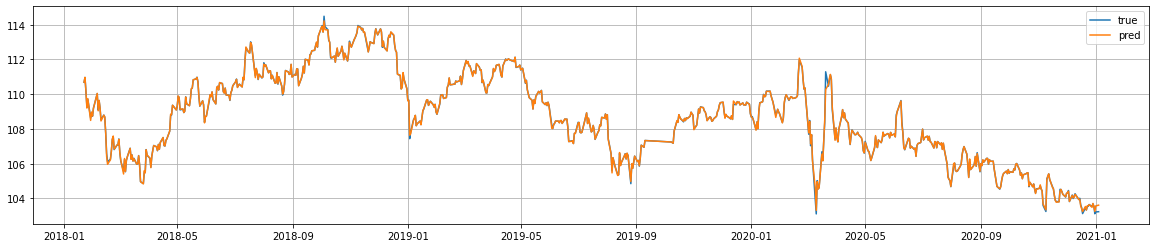

In [244]:
plt.figure(figsize=(20,4))
plt.plot(train.index,train['Close'])
plt.plot(train.index,reg.predict(train.drop('Close',axis=1)))
plt.legend(['true','pred'])
plt.grid()
plt.show()

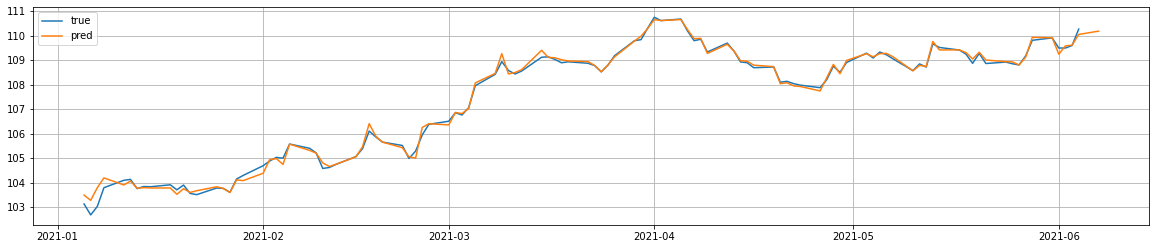

In [245]:
plt.figure(figsize=(20,4))
plt.plot(test.index[:-1],test[:-1]['Close'])
plt.plot(test.index,reg.predict(test.drop('Close',axis=1)))
plt.legend(['true','pred'])
plt.grid()
plt.show()

In [246]:
t = test[:-1]['Close'].diff()
t = t.mask(t>0,1)
t = t.mask(t<0,0)

In [247]:
y = pd.Series(reg.predict(test.drop('Close',axis=1)),index=test.index).diff()
y = y.mask(y>0,1)
y = y.mask(y<0,0)

In [248]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(t.dropna(),y[:-1].dropna()))

[[46  5]
 [11 46]]


In [249]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test[:-1]['Close'],reg.predict(test.drop('Close',axis=1))[:-1])

In [250]:
#直近半年の精度が0.1％以下なら取引する
if mape*100<0.1:
    #今日の引値より明日の予想引値が高いなら買い、逆なら売り
    if test['Close'][-2] < reg.predict(test.drop('Close',axis=1))[-1] and posses['JPY']!=0:
        posses['JPY'] = 0
        posses['USD'] += posses['JPY']/test['Close'][-2]
    elif test['Close'][-2] > reg.predict(test.drop('Close',axis=1))[-1] and posses['USD']!=0:
        posses['USD'] = 0
        posses['JPY'] += posses['USD']*test['Close'][-2]

In [251]:
posses

{'JPY': 10000, 'USD': 0}